Step 1: Load and preprocess the IMDB dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Preprocess the data
max_len = 200  # Limiting sequence length to 200 for padding
train_data = pad_sequences(train_data, maxlen=max_len, padding='post')
test_data = pad_sequences(test_data, maxlen=max_len, padding='post')

17464789/17464789 [==============================] - 2s 0us/step


Step 2: Define a custom RingAttention layer implementing ring attention.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class RingAttention(Layer):
    def __init__(self, num_heads=8, key_dim=128, **kwargs):
        super(RingAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim

    def build(self, input_shape):
        self.query_dense = Dense(self.key_dim, use_bias=False)
        self.key_dense = Dense(self.key_dim, use_bias=False)
        self.value_dense = Dense(self.key_dim, use_bias=False)
        super(RingAttention, self).build(input_shape)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Reshape for multi-head attention
        query = tf.reshape(query, (-1, tf.shape(query)[1], self.num_heads, self.key_dim // self.num_heads))
        key = tf.reshape(key, (-1, tf.shape(key)[1], self.num_heads, self.key_dim // self.num_heads))
        value = tf.reshape(value, (-1, tf.shape(value)[1], self.num_heads, self.key_dim // self.num_heads))

        # Transpose for attention calculation
        query = tf.transpose(query, perm=[0, 2, 1, 3])
        key = tf.transpose(key, perm=[0, 2, 1, 3])
        value = tf.transpose(value, perm=[0, 2, 1, 3])

        # Circular shift on keys
        key = tf.concat([key[:, :, -1:, :], key[:, :, :-1, :]], axis=-2)

        # Calculate attention scores
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)

        # Apply attention to values
        output = tf.matmul(attention_scores, value)

        # Transpose and reshape back to original shape
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (-1, tf.shape(output)[1], self.key_dim))

        return output

Step 3: Define a custom BlockwiseTransformer layer consisting of multiple blocks of ring attention and feed-forward networks.

In [ ]:
from tensorflow.keras.layers import LayerNormalization

class BlockwiseTransformer(Layer):
    def __init__(self, num_blocks=6, embed_dim=128, num_heads=8, mlp_dim=128, dropout=0.1, **kwargs):
        super(BlockwiseTransformer, self).__init__(**kwargs)
        self.num_blocks = num_blocks
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.attention_layers = [RingAttention(num_heads=self.num_heads, key_dim=self.embed_dim) for _ in range(self.num_blocks)]
        self.ffn_layers = [tf.keras.Sequential([
            Dense(self.mlp_dim, activation='relu'),
            Dense(self.embed_dim)
        ]) for _ in range(self.num_blocks)]
        self.layernorm1 = [LayerNormalization(epsilon=1e-6) for _ in range(self.num_blocks)]
        self.layernorm2 = [LayerNormalization(epsilon=1e-6) for _ in range(self.num_blocks)]
        super(BlockwiseTransformer, self).build(input_shape)

    def call(self, inputs):
        x = inputs

        for i in range(self.num_blocks):
            # Ring attention
            attn_output = self.attention_layers[i](x)
            attn_output = self.layernorm1[i](attn_output + x)

            # Feed-forward MLP
            ffn_output = self.ffn_layers[i](attn_output)
            x = self.layernorm2[i](ffn_output + attn_output)

        return x

In [ ]:
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def build_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=10000, output_dim=128)(inputs)  # Embedding layer
    x = BlockwiseTransformer(num_blocks=6, embed_dim=128, num_heads=8, mlp_dim=128, dropout=0.1)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_data, train_labels, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5
352/352 [==============================] - 44s 81ms/step - loss: 0.5507 - accuracy: 0.6803 - val_loss: 0.3206 - val_accuracy: 0.8592
Epoch 2/5
352/352 [==============================] - 17s 47ms/step - loss: 0.2469 - accuracy: 0.9045 - val_loss: 0.3057 - val_accuracy: 0.8824
Epoch 3/5
352/352 [==============================] - 14s 39ms/step - loss: 0.1743 - accuracy: 0.9351 - val_loss: 0.3298 - val_accuracy: 0.8720
Epoch 4/5
352/352 [==============================] - 12s 35ms/step - loss: 0.1444 - accuracy: 0.9484 - val_loss: 0.3493 - val_accuracy: 0.8728
Epoch 5/5
782/782 [==============================] - 8s 11ms/step - loss: 0.4116 - accuracy: 0.8555
Test Accuracy: 0.8555


Plotting the training and validation loss

In [ ]:
import matplotlib.pyplot as plt

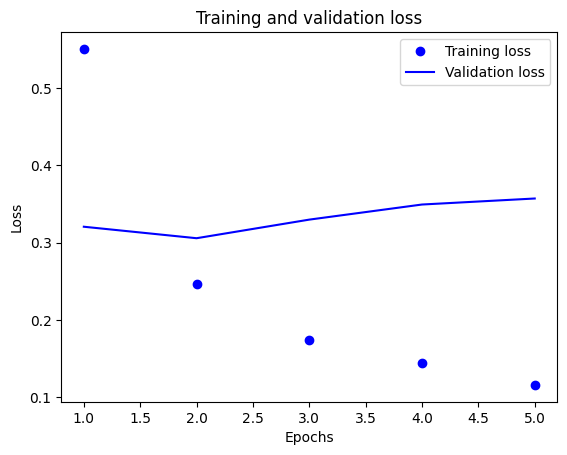

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plotting the training and validation accuracy

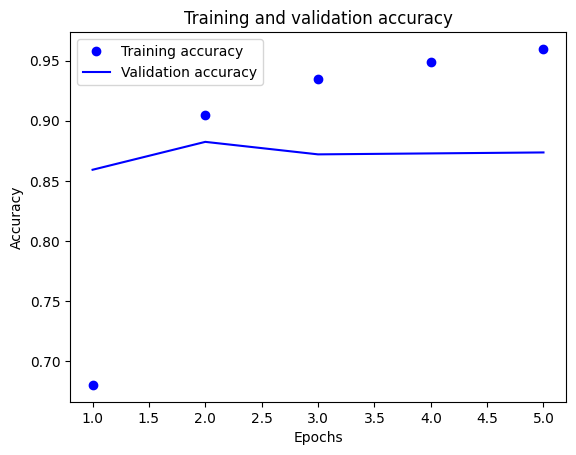

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
model.predict(test_data)

782/782 [==============================] - 9s 10ms/step


array([[0.01934421],
       [0.99492955],
       [0.9266383 ],
       ...,
       [0.08135927],
       [0.18948923],
       [0.9576044 ]], dtype=float32)